In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#test queries
engine.execute("SELECT * FROM station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [14]:
# Calculate the date 1 year ago from the last data point in the database
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > one_year).order_by(Measurement.date).all()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores_df = pd.DataFrame(prcp_scores)
prcp_scores_df.head()
prcp_scores_df.set_index("date").head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [17]:
# Sort the dataframe by date
prcp_scores_df.sort_index().head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


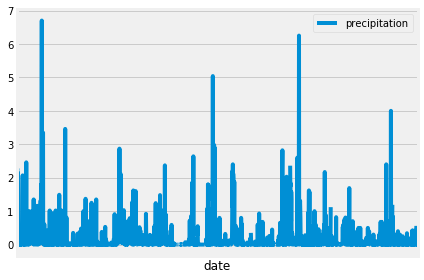

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_scores_df.plot("date", "prcp")
plt.xlabel("date")
plt.legend(["precipitation"])
plt.xticks([])
plt.yticks()
plt.tight_layout()
plt.savefig("Images/precipitations.png")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_scores_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
#Station Analysis

In [21]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).group_by(Station.station).count()
print(stations)

9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations  = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = active_stations[0][0]
most_active

'USC00519281'

In [24]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_active).\
filter(Measurement.date >= one_year).all()
top_station_df = pd.DataFrame(top_station)
top_station_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


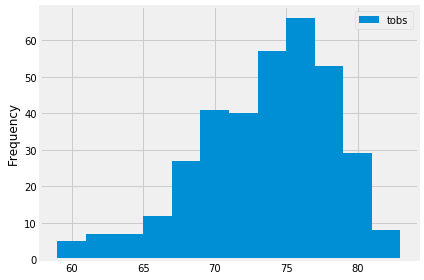

In [26]:
top_station_df.plot.hist(top_station_df["tobs"], 12)
plt.legend(["tobs"])
plt.ylabel("Frequency")
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()